## Imports

In [1]:
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import axes3d
from joblib import dump, load
import warnings
warnings.filterwarnings('ignore') 


import librosa
from librosa import display

from sklearn.metrics import confusion_matrix, classification_report
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.utils.multiclass import unique_labels
from sklearn.decomposition import PCA
from sklearn.cross_decomposition import CCA
from sklearn.utils import shuffle
from sklearn.preprocessing import StandardScaler

from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier

## Load Data

In [2]:
all_genres = ['blues','classical','country','disco','hiphop','jazz','metal','pop','reggae','rock']
num_songs = 100
sr = 22050
Y_LIMIT = 660000

In [3]:
class DataLoader():
    def __init__(self, seg=5):
        '''
        Initializes the DataLoader.
        
        Forces deteriminism by setting np.seed=1.
        
        self.SEG is the number of fixed-length segments, and the number of random crops to take
        self.SEG_LENGTH is the length of each fixed-length segment
        self.RANDOM_SEG_LENGTH is the length of each random crop
        
        self.train_idxs is a list of 750 training indices
        self.test_idxs is a list of 250 testing indices
        
        self.train_crop_idxs is a list of 750*self.SEG training indices, corresponding to the same indices above
        self.test_crop_idxs  is a list of 750*self.SEG testing indices,  corresponding to the same indices above
        
        eg. train_idxs      = [1, 2, 4, ...]
            train_crop_idxs = [10 ... 19, 20 ... 29, 40 ... 49, ...]
            
        Cropped X's retain the order of the uncropped X's
        i.e. the first 10 self.mfcc_fixed_crop entries correspond to the first self.mfcc entry.
        '''
        np.random.seed(1)
        self.X_mfcc = None
        self.X_mfcc_random_crop = None
        self.X_mfcc_fixed_crop = None
        
        self.X_chroma = None
        self.X_chroma_random_crop = None
        self.X_chroma_fixed_crop = None
        
        self.Y = None
        self.Y_crop = None
        
        self.SEG = seg   # Must evenly divide 30
        self.SEG_LENGTH = int(1290/self.SEG)
        self.RANDOM_SEG_LENGTH = 1200
        self.PAD = 1290 - self.RANDOM_SEG_LENGTH
        self.RANDOM_STARTS = np.random.randint(low=0, high=1290-self.RANDOM_SEG_LENGTH, size=(1000, self.SEG))
        
        self.train_idxs = np.sort(np.random.choice(np.array([i for i in range(1000)]), size=500, replace=False))
        self.val_idxs = np.sort(np.random.choice(np.array([i for i in range(1000) if i not in self.train_idxs]), size=250, replace=False))
        self.test_idxs = np.array([i for i in range(1000) if i not in self.train_idxs and i not in self.val_idxs])

        self.train_crop_idxs = np.hstack([np.array([i*self.SEG+j for j in range(self.SEG)]) for i in self.train_idxs])
        self.val_crop_idxs = np.hstack([np.array([i*self.SEG+j for j in range(self.SEG)]) for i in self.val_idxs])
        self.test_crop_idxs = np.hstack([np.array([i*self.SEG+j for j in range(self.SEG)]) for i in self.test_idxs])

    def save_mfcc(self, genres=all_genres, songs=num_songs):
        '''
        Saves MFCC Coefficients.
        Produces a 1000 x 16770 array.
        '''
        assert(self.X_mfcc is None)
        X_mfcc = None
        for g_idx, g in enumerate(genres):
            for s_idx in range(songs):
                y, sr = librosa.load(f'genres/{g}/{g}.000{s_idx:02d}.wav')
                y = y[:Y_LIMIT]
                mfcc = librosa.feature.mfcc(y, sr=sr, hop_length=512, n_mfcc=13).flatten()
                if X_mfcc is None:
                    X_mfcc = mfcc.reshape(1, mfcc.shape[0])
                else:
                    X_mfcc = np.vstack([X_mfcc, mfcc])
        scaler = StandardScaler()
        self.X_mfcc = scaler.fit_transform(X_mfcc)
        np.savetxt('data/X_mfcc.csv', self.X_mfcc)
    
    def save_mfcc_random_crop(self):
        '''
        Saves self.SEG random crops of MFCC for every original training sample.
        
        Produces a 10000 x 13 x 1200 array, padded with zeros to 10000 x 13 x 1290.
        Reshapes into 10000*16770 for the CSV.
        '''
        assert(self.X_mfcc_random_crop is None and self.X_mfcc is not None)
        X_mfcc_crop = None
        for i, mfcc in enumerate(self.X_mfcc):
            crop = None
            for j in range(self.SEG):
                random_start = self.RANDOM_STARTS[i][j]
                random_seg = np.vstack([mfcc[1290*k+random_start : 1290*k+random_start+self.RANDOM_SEG_LENGTH] for k in range(13)])
                random_seg = np.pad(random_seg, ((0, 0), (0, self.PAD)), 'constant')
                random_seg = random_seg.reshape(1, random_seg.shape[0], random_seg.shape[1])
                if crop is None:
                    crop = random_seg
                else:
                    crop = np.vstack([crop, random_seg])
            if X_mfcc_crop is None:
                X_mfcc_crop = crop
            else:
                X_mfcc_crop = np.vstack([X_mfcc_crop, crop])
        self.X_mfcc_random_crop = X_mfcc_crop
        np.savetxt(f'data/X_mfcc_random_crop_{self.SEG}.csv', X_mfcc_crop.reshape(1000*self.SEG, 13*1290))
    
    def save_mfcc_fixed_crop(self):
        '''
        Saves self.SEG even segments of MFCC for every original training sample.
        
        Produces a 10000 x 13 x 129 array of MFCC coefficients for the segments.
        Reshapes into 10000*1677 for the CSV.
        '''
        assert(self.X_mfcc_fixed_crop is None and self.X_mfcc is not None)
        X_mfcc_crop = None
        for mfcc in self.X_mfcc:
            crop = np.stack([np.vstack([mfcc[1290*j+self.SEG_LENGTH*i : 1290*j+self.SEG_LENGTH*(i+1)] for j in range(13)]) for i in range(self.SEG)], axis=0)
            if X_mfcc_crop is None:
                X_mfcc_crop = crop
            else:
                X_mfcc_crop = np.vstack([X_mfcc_crop, crop])
        self.X_mfcc_fixed_crop = X_mfcc_crop
        np.savetxt(f'data/X_mfcc_fixed_crop_{self.SEG}.csv', X_mfcc_crop.reshape(1000*self.SEG, 13*self.SEG_LENGTH))
    
    def save_chroma(self, genres=all_genres, songs=num_songs):
        '''
        Saves Chromas.
        Produces a 1000 x 15480 array.
        '''
        assert(self.X_chroma is None)
        X_chroma = None
        for g_idx, g in enumerate(genres):
            for s_idx in range(songs):
                y, sr = librosa.load(f'genres/{g}/{g}.000{s_idx:02d}.wav')
                y = y[:Y_LIMIT]
                chroma = librosa.feature.chroma_cqt(y, sr=sr, hop_length=512).flatten()
                if X_chroma is None:
                    X_chroma = chroma.reshape(1, chroma.shape[0])
                else:
                    X_chroma = np.vstack([X_chroma, chroma])
        scaler = StandardScaler()
        self.X_chroma = scaler.fit_transform(X_chroma)
        np.savetxt('data/X_chroma.csv', self.X_chroma)

    def save_chroma_random_crop(self):
        '''
        Saves 10 random crops of Chromas for every original training sample.
        
        Produces a 10000 x 12 x 1200 array, padded with zeros to 10000 x 12 x 1290.
        Reshapes into 10000*15480 for the CSV.
        '''
        assert(self.X_chroma_random_crop is None and self.X_chroma is not None)
        X_chroma_crop = None
        for i, chroma in enumerate(self.X_chroma):
            crop = None
            for j in range(self.SEG):
                random_start = self.RANDOM_STARTS[i][j]
                random_seg = np.vstack([chroma[1290*k+random_start : 1290*k+random_start+self.RANDOM_SEG_LENGTH] for k in range(12)])
                random_seg = np.pad(random_seg, ((0, 0), (0, self.PAD)), 'constant')
                random_seg = random_seg.reshape(1, random_seg.shape[0], random_seg.shape[1])
                if crop is None:
                    crop = random_seg
                else:
                    crop = np.vstack([crop, random_seg])
            if X_chroma_crop is None:
                X_chroma_crop = crop
            else:
                X_chroma_crop = np.vstack([X_chroma_crop, crop])
        self.X_chroma_random_crop = X_chroma_crop
        np.savetxt(f'data/X_chroma_random_crop_{self.SEG}.csv', X_chroma_crop.reshape(1000*self.SEG, 12*1290))
        
    def save_chroma_fixed_crop(self):
        '''
        Saves 10 even segments of Chromas for every original training sample.
        
        Produces a 10000 x 12 x 129 array of MFCC coefficients for the segments.
        Reshapes into 10000*1548 for the CSV.
        '''
        assert(self.X_chroma_fixed_crop is None and self.X_chroma is not None)
        X_chroma_crop = None
        for chroma in self.X_chroma:
            crop = np.stack([np.vstack([chroma[1290*j+self.SEG_LENGTH*i : 1290*j+self.SEG_LENGTH*(i+1)] for j in range(12)]) for i in range(self.SEG)], axis=0)
            if X_chroma_crop is None:
                X_chroma_crop = crop
            else:
                X_chroma_crop = np.vstack([X_chroma_crop, crop])
        self.X_chroma_fixed_crop = X_chroma_crop
        np.savetxt(f'data/X_chroma_fixed_crop_{self.SEG}.csv', X_chroma_crop.reshape(1000*self.SEG, 12*self.SEG_LENGTH))
    
    '''
    If X_mfcc has been saved, but we aborted before saving X_mfcc_random_crop (or X_mfcc_fixed_crop), 
    we can call load_mfcc with tensor=False to load the MFCC in 2D and then call dl.save_random_crop().
    Note that all load functions reshape into tensors by default.
    '''  
    
    def load_mfcc(self, tensor=True):
        self.X_mfcc = np.loadtxt('data/X_mfcc.csv')
        if tensor:
            self.X_mfcc = self.X_mfcc.reshape(1000, 13, 1290)
    
    def load_mfcc_random_crop(self):
        self.X_mfcc_random_crop = np.loadtxt(f'data/X_mfcc_random_crop_{self.SEG}.csv').reshape(1000*self.SEG, 13, 1290)
        
    def load_mfcc_fixed_crop(self):
        self.X_mfcc_fixed_crop = np.loadtxt(f'data/X_mfcc_fixed_crop_{self.SEG}.csv').reshape(1000*self.SEG, 13, self.SEG_LENGTH)
        
    def load_chroma(self, tensor=True):
        self.X_chroma = np.loadtxt('data/X_chroma.csv')
        if tensor:
            self.X_chroma = self.X_chroma.reshape(1000, 12, 1290)
    
    def load_chroma_random_crop(self):
        self.X_chroma_random_crop = np.loadtxt(f'data/X_chroma_random_crop_{self.SEG}.csv').reshape(1000*self.SEG, 12, 1290)
        
    def load_chroma_fixed_crop(self):
        self.X_chroma_fixed_crop = np.loadtxt(f'data/X_chroma_fixed_crop_{self.SEG}.csv').reshape(1000*self.SEG, 12, self.SEG_LENGTH)
    
    def load_Y(self):
        self.Y = np.array([int(i/100) for i in range(1000)]).ravel()
        
    def load_Y_crop(self):
        self.Y_crop = np.array([int(i/(100 * self.SEG)) for i in range(1000 * self.SEG)]).ravel()
        
    def train_test_val_split(self, data, is_cropped):
        '''
        Splits an X_data into train, validation, and test sets.
        
        is_cropped=True for splitting random or fixed crops, iscropped=False for splitting original mfcc/chroma
        
        Train, val, and test indices are consistent every time train_test_split is called.
        
        Furthermore, cropped train and test indices are returned so that batches of size self.SEG are together, 
        with each batch corresponding to a single non-cropped index.
        '''
        if is_cropped:
            return np.take(data, self.train_crop_idxs, 0), np.take(data, self.val_crop_idxs, 0), np.take(data, self.test_crop_idxs, 0)
        else:
            return np.take(data, self.train_idxs, 0), np.take(data, self.val_idxs, 0), np.take(data, self.test_idxs, 0)

In [4]:
%%time
dl = DataLoader(5)
dl.load_mfcc()
# dl.load_mfcc_fixed_crop()
dl.load_mfcc_random_crop()
dl.load_chroma()
# dl.load_chroma_fixed_crop()
dl.load_chroma_random_crop()
dl.load_Y()
dl.load_Y_crop()

CPU times: user 2min 47s, sys: 5.9 s, total: 2min 52s
Wall time: 3min 6s


## Graphics for Results

In [5]:
def plot_confusion_matrix(test_labels, predictions, title):
    ax= plt.subplot()
    cm = confusion_matrix(test_labels, predictions)
    sns.heatmap(cm, annot=True, ax = ax, cmap = sns.cm.rocket_r); #annot=True to annotate cells

    # labels, title and ticks
    ax.set_xlabel('Predicted labels');ax.set_ylabel('True labels'); 
    ax.set_title(f'{title}'); 
    ax.set_ylim(top=0, bottom=10)
    ax.xaxis.set_ticklabels(all_genres); ax.yaxis.set_ticklabels(all_genres);
    plt.setp(ax.get_xticklabels(), rotation=45, ha="right",
                 rotation_mode="anchor")
    plt.setp(ax.get_yticklabels(), rotation=45, ha="right",
                 rotation_mode="anchor")
    plt.show()

In [6]:
def plot_labels_3d(data, labels, title, pca_X):
    pca = PCA(n_components=3, random_state=1)
    pca.fit(pca_X) # Matrix to PCA on
    projected = pca.transform(data)
    fig = plt.figure(figsize=(15,10))
    fig.suptitle(title, fontsize=20) 
    ax = fig.add_subplot(111, projection='3d')
    for l, c in zip(range(0, 10),
                    ('blue', 'red', 'green', 'orange', 'yellow', 'black', 'purple', 'cyan', 'brown', 'pink')):
        ax.scatter(projected[labels == l, 0],
                    projected[labels == l, 1],
                    projected[labels == l, 2],
                    color=c,
                    label='%s' % all_genres[l],
                    alpha=.5,
                    marker='o',
                    s=60
                    )
    ax.set_xlabel('PCA dimension 1')
    ax.set_ylabel('PCA dimension 2')
    ax.set_zlabel('PCA dimension 3')
    plt.grid()
    plt.legend(loc='upper right')
    plt.show()
    

## Vanilla Baselines

In [7]:
# Train on X_train (750),
# Test on X_test (250)
print('Train, validate, and test the vanilla model\n')

Xm_train, Xm_val, Xm_test = dl.train_test_val_split(dl.X_mfcc, is_cropped=False)
Xc_train, Xc_val, Xc_test = dl.train_test_val_split(dl.X_chroma, is_cropped=False)

X_train = np.concatenate([Xm_train, Xc_train], axis=1)
X_val = np.concatenate([Xm_val, Xc_val], axis=1)
X_test = np.concatenate([Xm_test, Xc_test], axis=1)

Y_train, Y_val, Y_test = dl.train_test_val_split(dl.Y, is_cropped=False)

print(f'Train size:    {X_train.shape}', f'     Train labels size: {Y_train.shape}')
print(f'Val size:      {X_val.shape}', f'     Val labels size:   {Y_val.shape}')
print(f'Test size:     {X_test.shape}', f'     Test labels size:  {Y_test.shape}')

Train, validate, and test the vanilla model

Train size:    (500, 25, 1290)      Train labels size: (500,)
Val size:      (250, 25, 1290)      Val labels size:   (250,)
Test size:     (250, 25, 1290)      Test labels size:  (250,)


In [8]:
# For SVM, need to reshape to 2D:
def reshape2D(data):
    return np.reshape(data, (data.shape[0], data.shape[1]*data.shape[2]))
    
X_train = reshape2D(X_train)
X_val = reshape2D(X_val)
X_test = reshape2D(X_test)
    
print(f'Train size:    {X_train.shape}', f'     Train labels size: {Y_train.shape}')
print(f'Val size:      {X_val.shape}', f'     Val labels size:   {Y_val.shape}')
print(f'Test size:     {X_test.shape}', f'     Test labels size:  {Y_test.shape}')

Train size:    (500, 32250)      Train labels size: (500,)
Val size:      (250, 32250)      Val labels size:   (250,)
Test size:     (250, 32250)      Test labels size:  (250,)


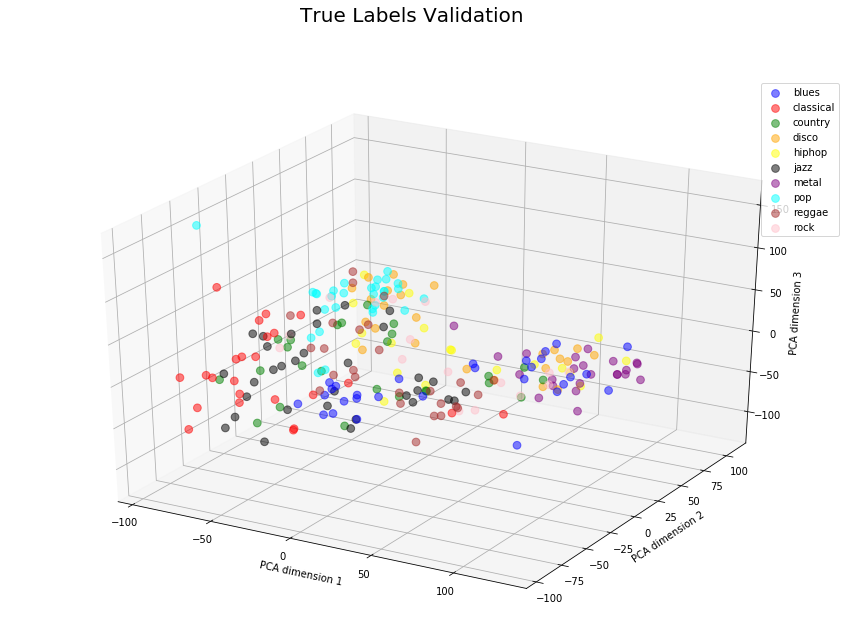

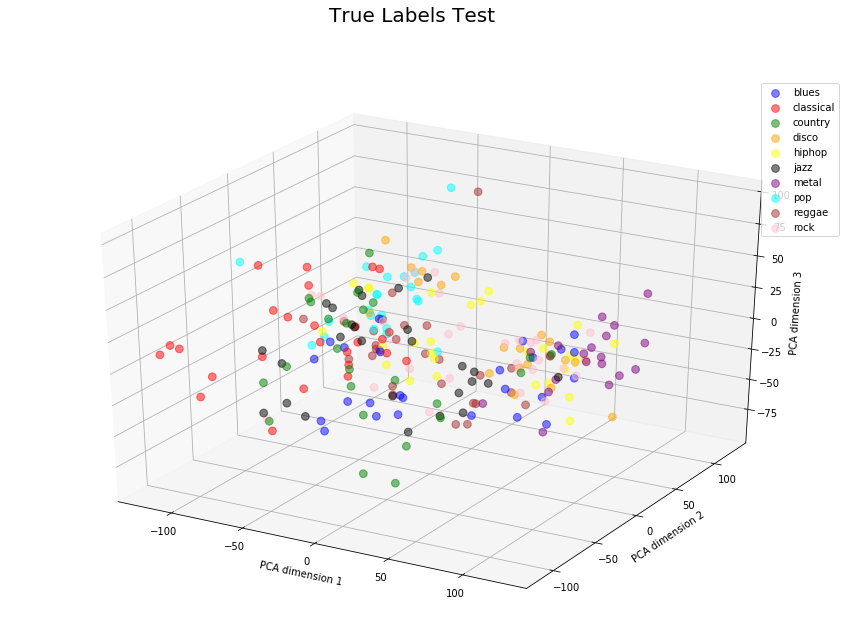

In [9]:
plot_labels_3d(X_val, Y_val, 'True Labels Validation', X_val)
plot_labels_3d(X_test, Y_test, 'True Labels Test', X_test)

---------------------------SVM-------------------------------
TRAIN: 0.998, VALIDATION: 0.56, TEST:0.572


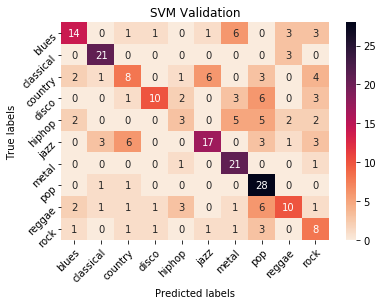

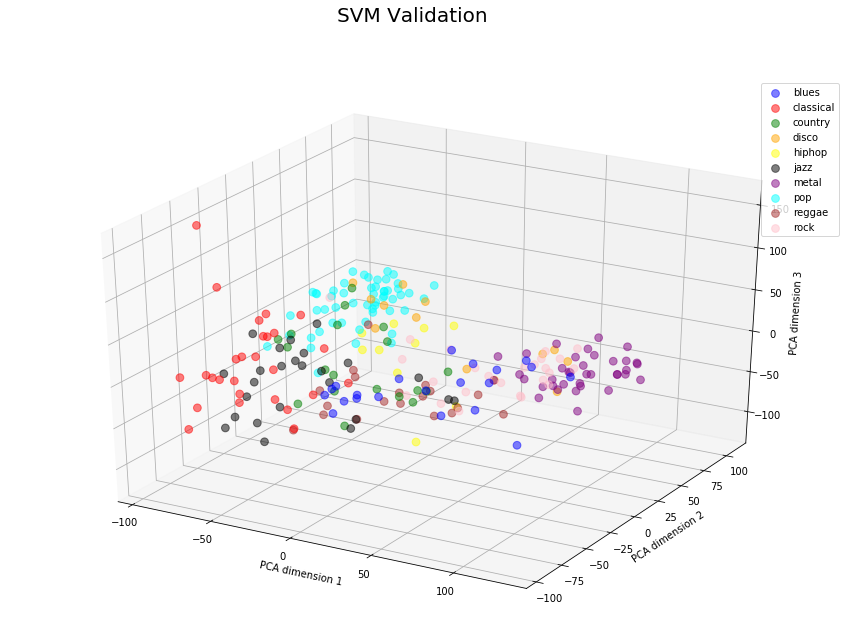

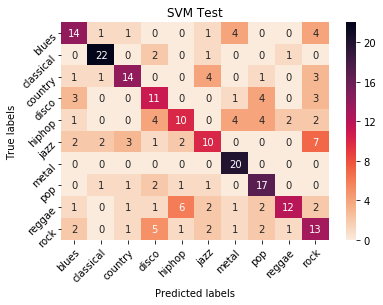

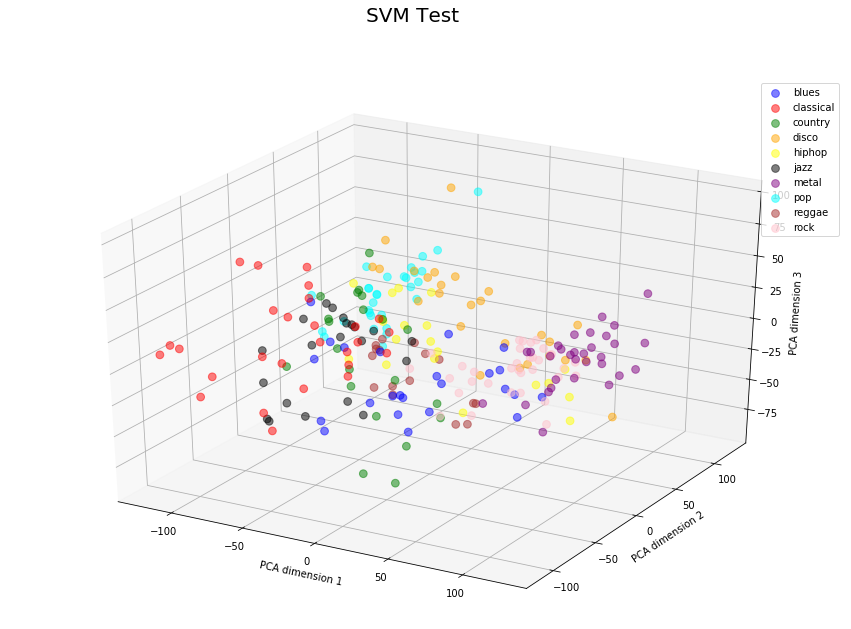

In [19]:
# Train and Validate. We're not varying any parameters here, so we only have one model to choose from.
# svm_model = SVC(kernel='rbf', gamma=1e-5, C=10)
title = 'SVM'
print(f'---------------------------{title}-------------------------------')
# svm_model.fit(X_train, Y_train)
train_pred = svm_model.predict(X_train)
val_pred = svm_model.predict(X_val)
test_pred = svm_model.predict(X_test)
print(f'TRAIN: {np.sum(Y_train == train_pred)/500}, VALIDATION: {np.sum(Y_val == val_pred)/250}, TEST:{np.sum(Y_test == test_pred)/250}')

plot_confusion_matrix(Y_val, val_pred, f'{title} Validation')
plot_labels_3d(X_val, val_pred, f'{title} Validation', X_val)

plot_confusion_matrix(Y_test, test_pred, f'{title} Test')
plot_labels_3d(X_test, test_pred, f'{title} Test', X_test)

---------------------------Logistic Regression-------------------------------
TRAIN: 0.998, VALIDATION: 0.492, TEST:0.516


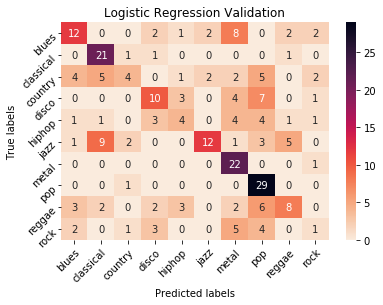

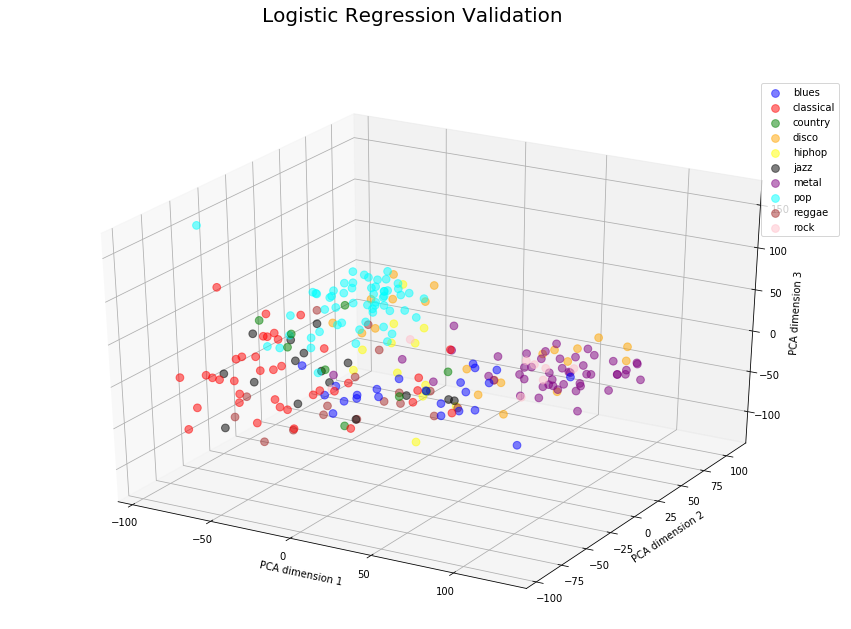

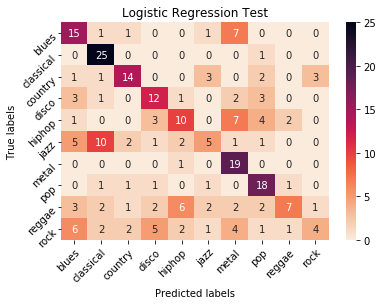

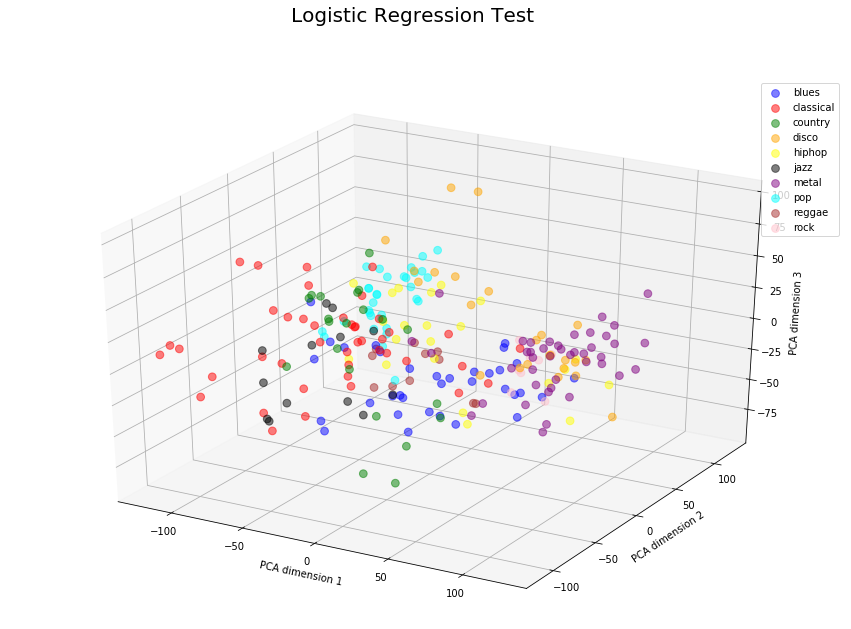

In [23]:
# Train and Validate. We're not varying any parameters here, so we only have one model to choose from.
# lr = LogisticRegression(solver='saga', multi_class='multinomial', max_iter=10, C=.01)
title = 'Logistic Regression'
print(f'---------------------------{title}-------------------------------')
# lr.fit(X_train, Y_train)
train_pred = lr.predict(X_train)
val_pred = lr.predict(X_val)
test_pred = lr.predict(X_test)
print(f'TRAIN: {np.sum(Y_train == train_pred)/500}, VALIDATION: {np.sum(Y_val == val_pred)/250}, TEST:{np.sum(Y_test == test_pred)/250}')

plot_confusion_matrix(Y_val, val_pred, f'{title} Validation')
plot_labels_3d(X_val, val_pred, f'{title} Validation', X_val)

plot_confusion_matrix(Y_test, test_pred, f'{title} Test')
plot_labels_3d(X_test, test_pred, f'{title} Test', X_test)

---------------------------Random Forest-------------------------------
TRAIN: 0.998, VALIDATION: 0.448, TEST:0.44


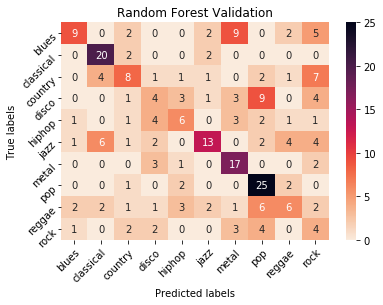

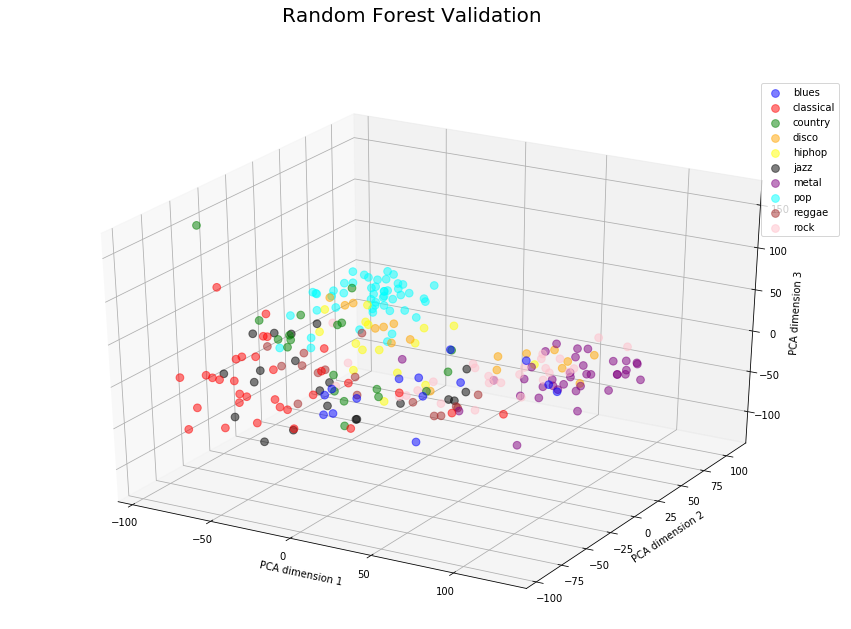

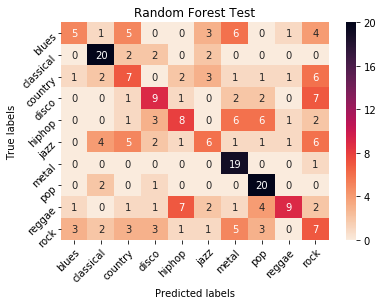

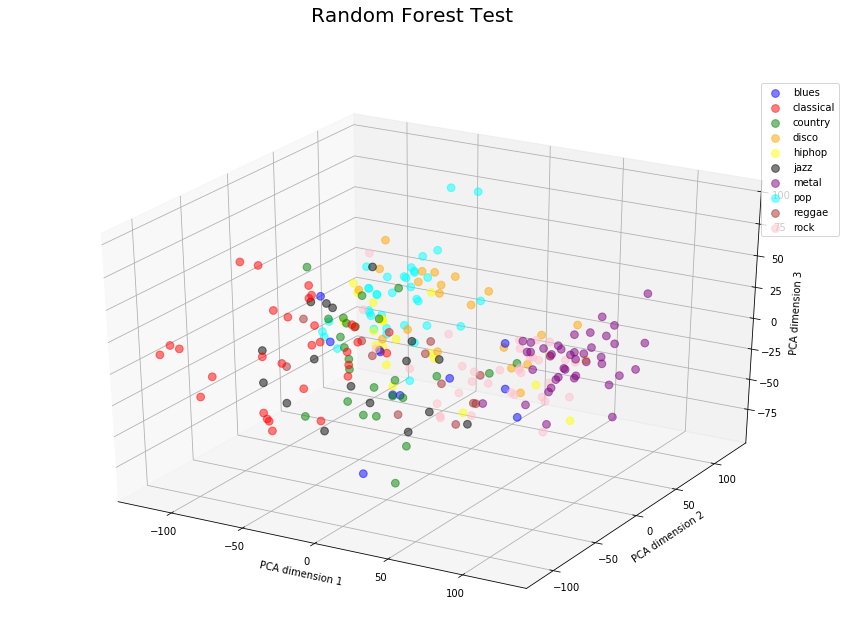

In [25]:
# Train and Validate. We're not varying any parameters here, so we only have one model to choose from.
# rf = RandomForestClassifier(n_estimators=80, max_features='sqrt')
title = 'Random Forest'
print(f'---------------------------{title}-------------------------------')
# rf.fit(X_train, Y_train)
train_pred = rf.predict(X_train)
val_pred = rf.predict(X_val)
test_pred = rf.predict(X_test)
print(f'TRAIN: {np.sum(Y_train == train_pred)/500}, VALIDATION: {np.sum(Y_val == val_pred)/250}, TEST:{np.sum(Y_test == test_pred)/250}')

plot_confusion_matrix(Y_val, val_pred, f'{title} Validation')
plot_labels_3d(X_val, val_pred, f'{title} Validation', X_val)

plot_confusion_matrix(Y_test, test_pred, f'{title} Test')
plot_labels_3d(X_test, test_pred, f'{title} Test', X_test)

## Fixed Crop Models

In [34]:
# Train on X_mfcc_fixed_crop_train (7500),
# Test on X_mfcc_fixed_crop_test (2500),
# Aggregate into predictions on X_mfcc_test (250)
print('Train on segments, validate and test by accumulating votes of segments\n')

Xmf_train, Xmf_val, Xmf_test = \
    dl.train_test_val_split(dl.X_mfcc_fixed_crop, is_cropped=True)
Xcf_train, Xcf_val, Xcf_test = \
    dl.train_test_val_split(dl.X_chroma_fixed_crop, is_cropped=True)

Xf_train = np.concatenate([Xmf_train, Xcf_train], axis=1)
Xf_val = np.concatenate([Xmf_val, Xcf_val], axis=1)
Xf_test = np.concatenate([Xmf_test, Xcf_test], axis=1)

Y_crop_train, _, _ = dl.train_test_val_split(dl.Y_crop, is_cropped=True)

print(f'Train size:  {Xf_train.shape}', f'     Train labels size: {Y_crop_train.shape}')
print(f'Val size:    {Xf_val.shape}', f'     Val labels size:   {Y_val.shape}')
print(f'Test size:   {Xf_test.shape}', f'     Test labels size:  {Y_test.shape}')

Train on segments, validate and test by accumulating votes of segments

Train size:  (2500, 25, 258)      Train labels size: (2500,)
Val size:    (1250, 25, 258)      Val labels size:   (250,)
Test size:   (1250, 25, 258)      Test labels size:  (250,)


In [36]:
# For SVM, need to reshape to 2D:
Xf_train = reshape2D(Xf_train)
Xf_val = reshape2D(Xf_val)
Xf_test = reshape2D(Xf_test)
    
print(f'Train size:  {Xf_train.shape}', f'     Train labels size: {Y_crop_train.shape}')
print(f'Val size:    {Xf_val.shape}', f'     Val labels size:   {Y_val.shape}')
print(f'Test size:   {Xf_test.shape}', f'     Test labels size:  {Y_test.shape}')

Train size:  (2500, 6450)      Train labels size: (2500,)
Val size:    (1250, 6450)      Val labels size:   (250,)
Test size:   (1250, 6450)      Test labels size:  (250,)


In [38]:
# Train and Validate. Eventually going to do this for several self.SEGs, but just doing this for self.SEG=5 for now.
svm_model = SVC(kernel='rbf', gamma=1e-5, C=10)
svm_model.fit(Xf_train, Y_crop_train)

SVC(C=10, cache_size=200, class_weight=None, coef0=0.0,
    decision_function_shape='ovr', degree=3, gamma=1e-05, kernel='rbf',
    max_iter=-1, probability=False, random_state=None, shrinking=True,
    tol=0.001, verbose=False)

In [44]:
# Batch up our predictions!
unbatched_predictions = svm_model.predict(Xf_val)

def vote(arr):
    unique, counts = np.unique(arr, return_counts=True)
    counts = dict(zip(unique, counts))
    counts = [(k, v) for k, v in counts.items()]
    counts.sort(key=lambda x : x[1], reverse=True)
    out = []
    max_occurrences = counts[0][1]
    for i in range(len(counts)):
        if counts[i][1] == max_occurrences:
            out.append(counts[i][0])
        else:
            break
    out_arr = np.array(out)
    np.random.seed(1)
    return np.random.choice(out, size=1)
    
def batchify(pred, seg):
    num_songs = int(pred.shape[0]/seg)
    return np.array([vote(pred[i*seg:(i+1)*seg]) for i in range(num_songs)]).ravel()

svm_predictions = batchify(unbatched_predictions, 5)

              precision    recall  f1-score   support

           0       0.57      0.41      0.48        29
           1       0.74      0.83      0.78        24
           2       0.33      0.24      0.28        25
           3       0.50      0.44      0.47        25
           4       0.31      0.21      0.25        19
           5       0.68      0.45      0.55        33
           6       0.68      0.83      0.75        23
           7       0.60      0.93      0.73        30
           8       0.45      0.38      0.42        26
           9       0.23      0.44      0.30        16

    accuracy                           0.53       250
   macro avg       0.51      0.52      0.50       250
weighted avg       0.53      0.53      0.52       250



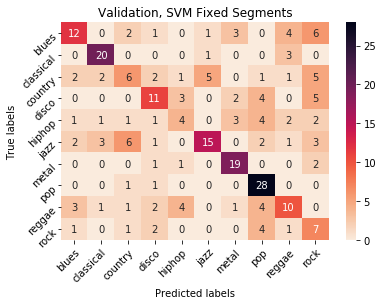

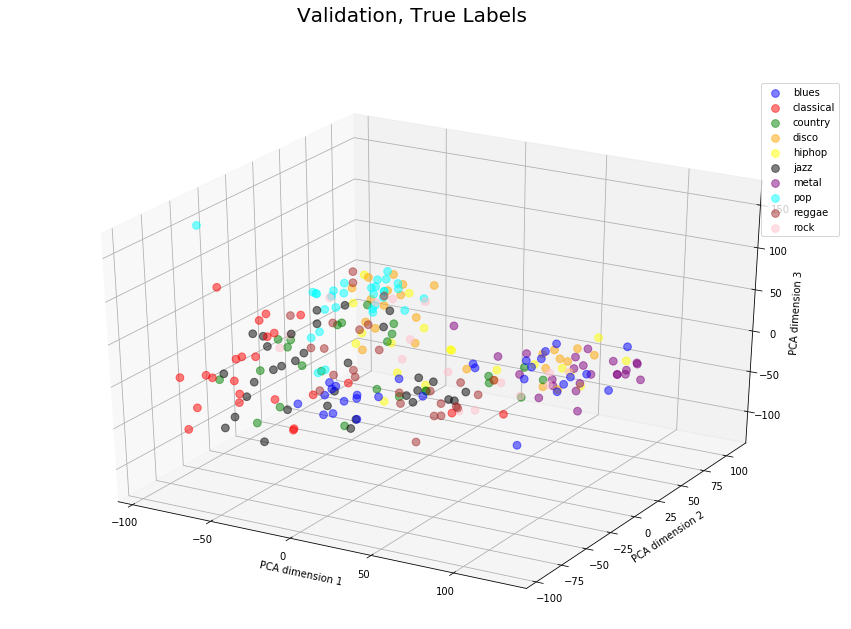

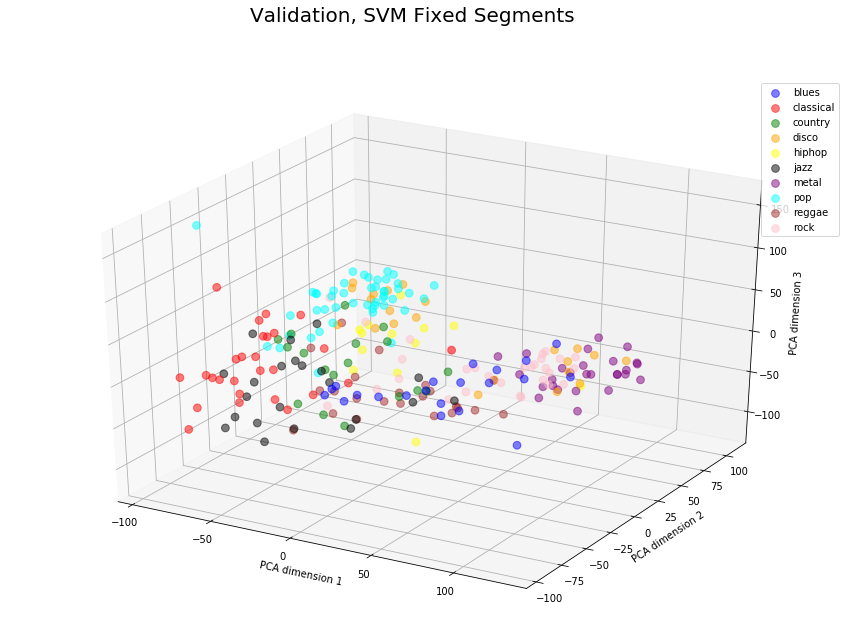

In [45]:
# Validation
print(classification_report(Y_val,svm_predictions))
plot_confusion_matrix(Y_val, svm_predictions, f'Validation, SVM Fixed Segments')
plot_labels_3d(X_val, Y_val, 'Validation, True Labels', X_val)
plot_labels_3d(X_val, svm_predictions, 'Validation, SVM Fixed Segments', X_val)

              precision    recall  f1-score   support

           0       0.54      0.52      0.53        25
           1       0.81      0.85      0.83        26
           2       0.57      0.67      0.62        24
           3       0.41      0.41      0.41        22
           4       0.45      0.48      0.46        27
           5       0.69      0.41      0.51        27
           6       0.67      0.90      0.77        20
           7       0.64      0.78      0.71        23
           8       0.78      0.50      0.61        28
           9       0.39      0.43      0.41        28

    accuracy                           0.58       250
   macro avg       0.59      0.59      0.58       250
weighted avg       0.60      0.58      0.58       250



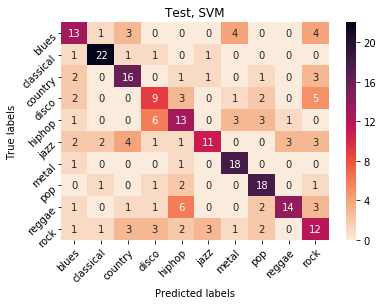

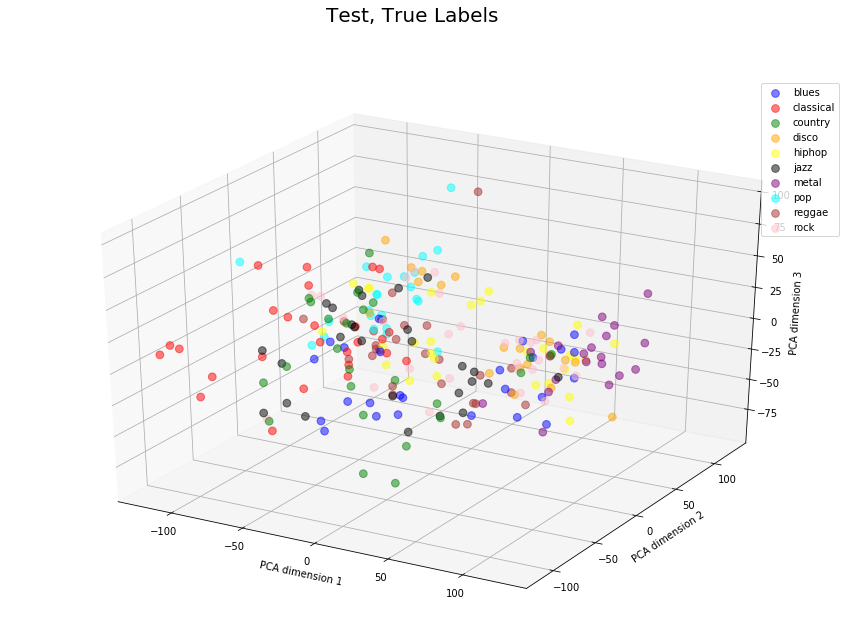

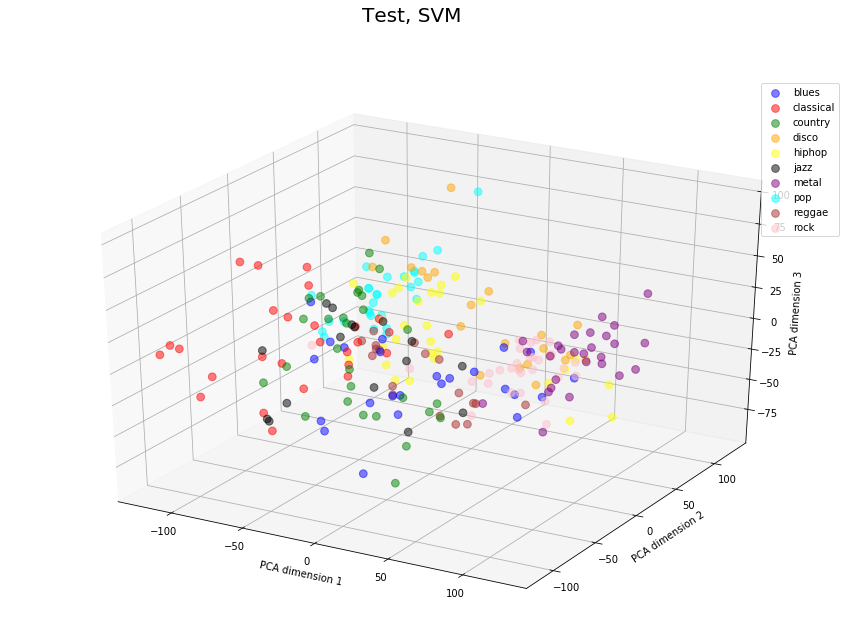

In [46]:
# Test
unbatched_predictions = svm_model.predict(Xf_test)
svm_predictions = batchify(unbatched_predictions, 5)
print(classification_report(Y_test,svm_predictions))
plot_confusion_matrix(Y_test, svm_predictions, f'Test, SVM')
plot_labels_3d(X_test, Y_test, 'Test, True Labels', X_test)
plot_labels_3d(X_test, svm_predictions, 'Test, SVM', X_test)

## Random Crop Models

In [10]:
# Train on X_mfcc_random_crop_train (7500),
# Test on X_mfcc_test (250)
print('Train on padded random crops, validate and test on uncropped test\n')

Xmr_train, _, _ = dl.train_test_val_split(dl.X_mfcc_random_crop, is_cropped=True)
Xcr_train, _, _ = dl.train_test_val_split(dl.X_chroma_random_crop, is_cropped=True)

Xr_train = np.concatenate([Xmr_train, Xcr_train], axis=1)

Y_crop_train, _, _ = dl.train_test_val_split(dl.Y_crop, is_cropped=True)

print(f'Train size:   {Xr_train.shape}', f'    Train labels size: {Y_crop_train.shape}')
print(f'Val size:     {X_val.shape}', f'        Val labels size:   {Y_val.shape}')
print(f'Test size:    {X_test.shape}', f'        Test labels size:  {Y_test.shape}')

Train on padded random crops, validate and test on uncropped test

Train size:   (2500, 25, 1290)     Train labels size: (2500,)
Val size:     (250, 32250)         Val labels size:   (250,)
Test size:    (250, 32250)         Test labels size:  (250,)


In [11]:
# For SVM, need to reshape to 2D:
Xr_train = reshape2D(Xr_train)
    
print(f'Train size:  {Xr_train.shape}', f'     Train labels size: {Y_crop_train.shape}')
print(f'Val size:    {X_val.shape}', f'        Val labels size:   {Y_val.shape}')
print(f'Test size:   {X_test.shape}', f'        Test labels size:  {Y_test.shape}')

Train size:  (2500, 32250)      Train labels size: (2500,)
Val size:    (250, 32250)         Val labels size:   (250,)
Test size:   (250, 32250)         Test labels size:  (250,)


              precision    recall  f1-score   support

           0       0.60      0.52      0.56        29
           1       0.83      0.79      0.81        24
           2       0.52      0.56      0.54        25
           3       0.50      0.44      0.47        25
           4       0.43      0.47      0.45        19
           5       0.63      0.52      0.57        33
           6       0.75      0.78      0.77        23
           7       0.63      0.80      0.71        30
           8       0.48      0.42      0.45        26
           9       0.25      0.31      0.28        16

    accuracy                           0.57       250
   macro avg       0.56      0.56      0.56       250
weighted avg       0.58      0.57      0.57       250



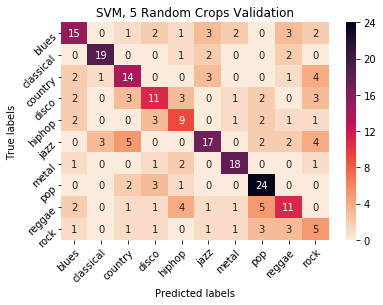

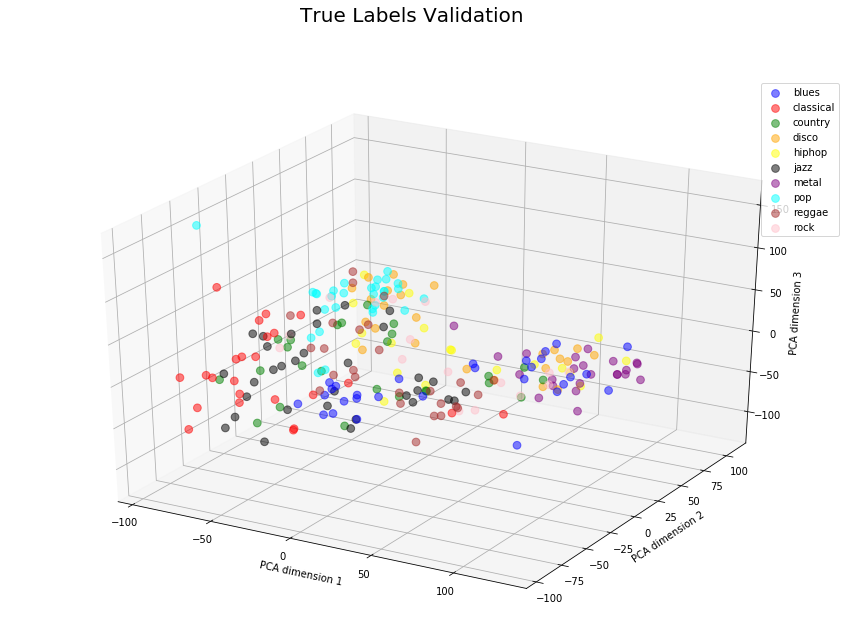

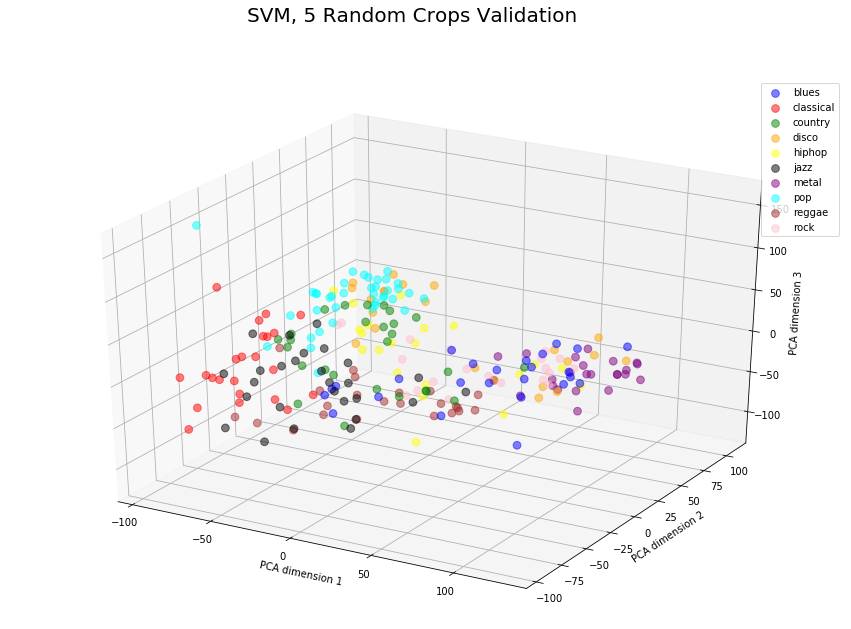

In [12]:
# Train and Validate. Eventually we'll do this for a loop over different self.SEGs.
svm_model = SVC(kernel='rbf', gamma=1e-5, C=10)
svm_model.fit(Xr_train, Y_crop_train)
svm_predictions = svm_model.predict(X_val)
print(classification_report(Y_val,svm_predictions))
plot_confusion_matrix(Y_val, svm_predictions, f'SVM, 5 Random Crops Validation')
plot_labels_3d(X_val, Y_val, 'True Labels Validation', X_val)
plot_labels_3d(X_val, svm_predictions, 'SVM, 5 Random Crops Validation', X_val)

TEST:0.576
              precision    recall  f1-score   support

           0       0.54      0.60      0.57        25
           1       0.74      0.65      0.69        26
           2       0.48      0.50      0.49        24
           3       0.46      0.59      0.52        22
           4       0.56      0.56      0.56        27
           5       0.50      0.41      0.45        27
           6       0.74      0.85      0.79        20
           7       0.75      0.78      0.77        23
           8       0.70      0.57      0.63        28
           9       0.37      0.36      0.36        28

    accuracy                           0.58       250
   macro avg       0.58      0.59      0.58       250
weighted avg       0.58      0.58      0.57       250



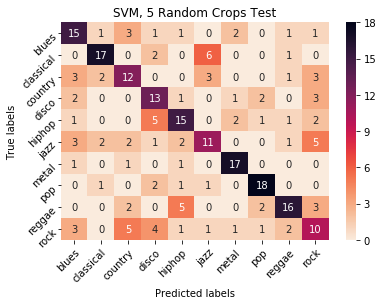

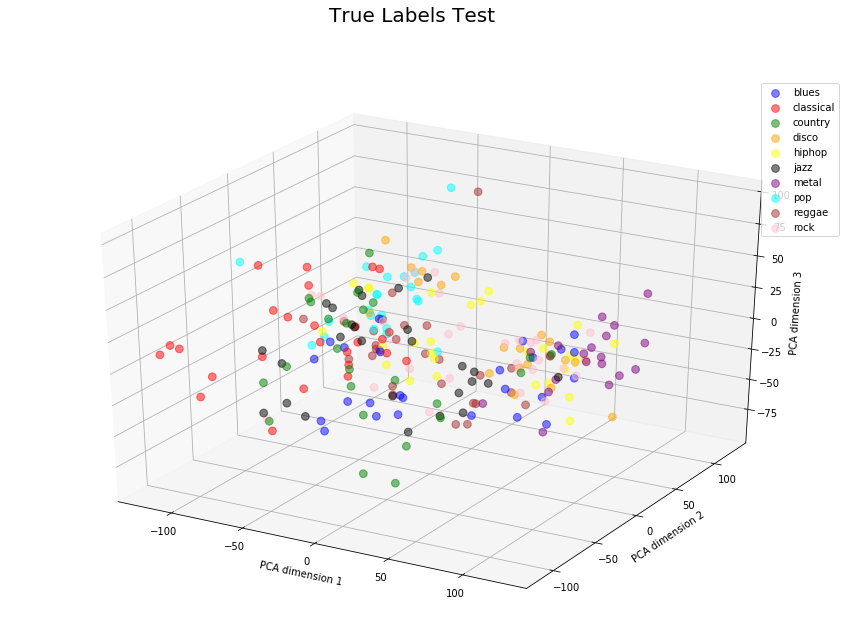

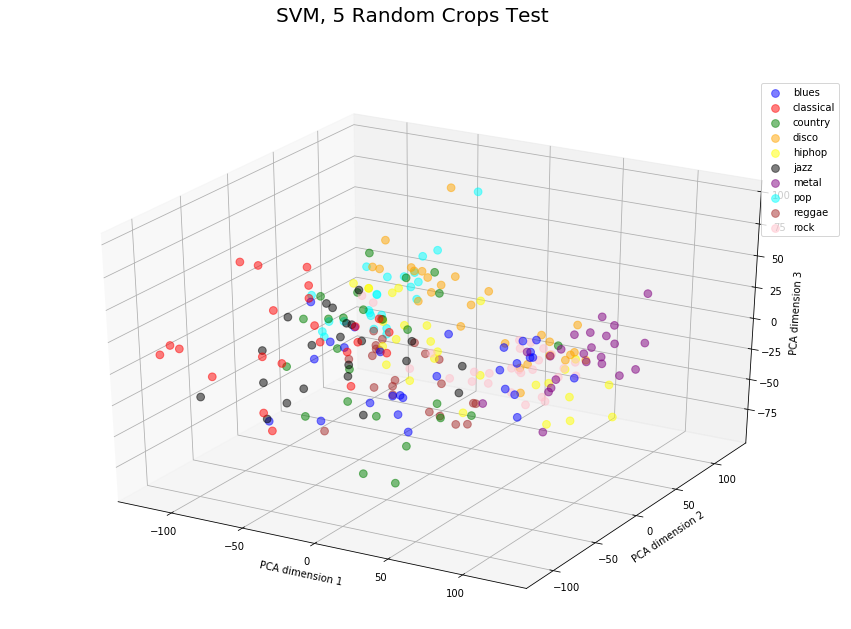

In [15]:
# Test
svm_predictions = svm_model.predict(X_test)
print(f'TEST:{np.sum(Y_test == svm_predictions)/250}')
print(classification_report(Y_test,svm_predictions))
plot_confusion_matrix(Y_test, svm_predictions, f'SVM, 5 Random Crops Test')
plot_labels_3d(X_test, Y_test, 'True Labels Test', X_test)
plot_labels_3d(X_test, svm_predictions, 'SVM, 5 Random Crops Test', X_test)